# Here we make a Random Forest Model For Prochlorococcus


In [35]:
# Running model preperation notebook that has a function we need to call
%run /Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/python/04_Populations-model-fitting/01_model-preparation.ipynb


In [36]:
#loading packages for random forest modeling

from sklearn.model_selection import train_test_split
import joblib

## RF Regressor for Prochlorococcus

### First we are making a graph to determine the best testing to training ratio 

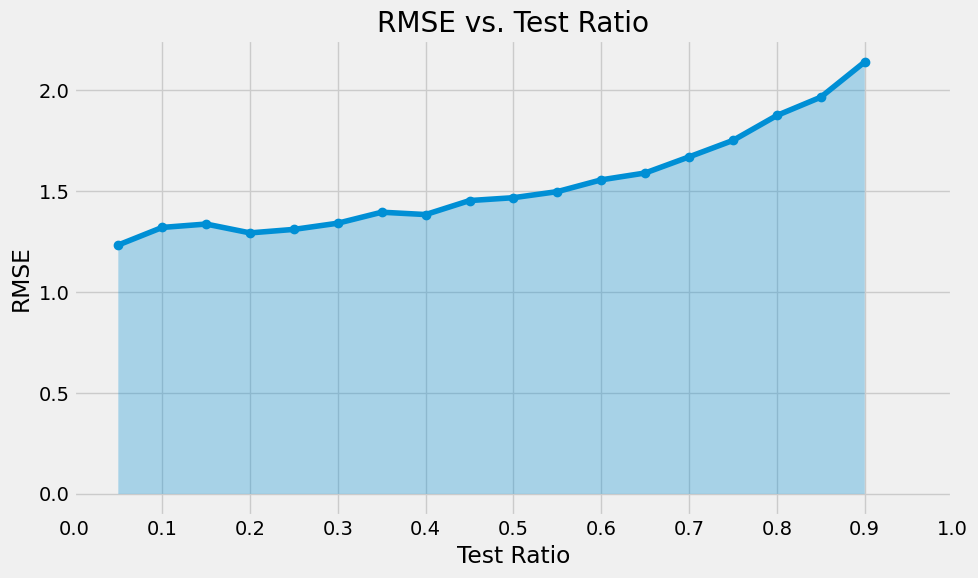

In [37]:
#using a function defined in the model prepe ration notebook
RMSEs = testing_training_ratio(features = features_pro, labels = labels_pro, feature_list=feature_list_pro)

## RF Regressor for Prochlorococcus

In [38]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets"
train_features, test_features, train_labels, test_labels = train_test_split(features_pro, labels_pro, test_size = 0.7, random_state = 42)

In [39]:
# Looking at the shape of the features and labels to see if they match up
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (717, 22)
Training Labels Shape: (717,)
Testing Features Shape: (1676, 22)
Testing Labels Shape: (1676,)


In [40]:
# We are using a regressor RF model because we are predicting on continous values
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Use the Training data to build the model
rf.fit(train_features, train_labels)
#saving the model
joblib.dump(rf, "/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/RF_models/pro_random_forest.joblib")


['/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/RF_models/pro_random_forest.joblib']

### Predicting and Testing for Prochlorococus

In [41]:
# Convert test_features to a DataFrame
test_features_df = pd.DataFrame(test_features, columns=feature_list_pro)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Create a new Series with predicted values and index from test_features_df
predic_biomass = pd.Series(predictions, index=test_features_df.index)

# Assign the new Series to the DataFrame using .loc
test_features_df.loc[:, 'Prediction'] = predic_biomass

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'pgC per L.')

# Finding the root mean square error (RMSE)
from sklearn.metrics import mean_squared_error
# RMSE give realtively high weight to large errors 
RMSE = mean_squared_error(test_labels, predictions, squared=False) #setting squared=False gives us RMSE not MSE
print('Root Mean Squre Error:', round(RMSE, 2), 'pgC per L.')


Mean Absolute Error: 1.1 pgC per L.
Root Mean Squre Error: 1.67 pgC per L.


In [42]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_pro, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

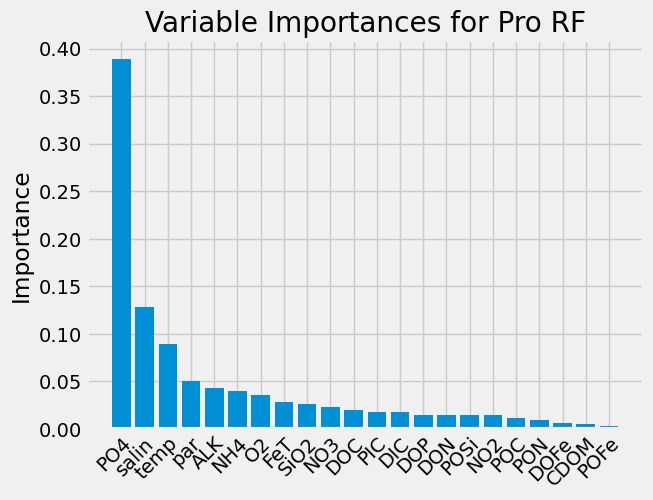

In [43]:
feature_importance = pd.DataFrame(rf.feature_importances_, index=feature_list_pro).sort_values(by=0, ascending=False)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# Make a bar chart
plt.bar(x=feature_importance.index,height=feature_importance[0], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(feature_importance.index, rotation=45, ha='right', rotation_mode='anchor')

# Axis labels and title
plt.ylabel('Importance'); plt.title('Variable Importances for Pro RF');

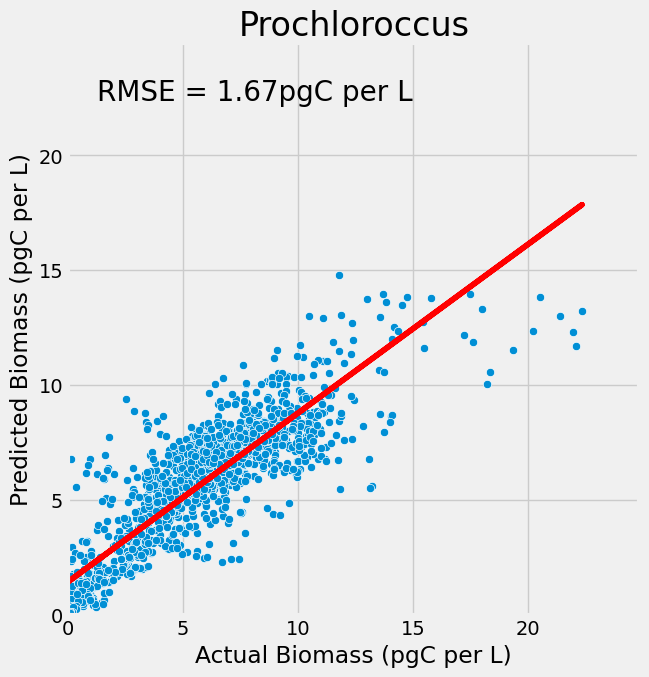

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import seaborn as sns

def plot_model_predictions():
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    
        
    # PRO Model Predictions vs True Values
    sns.scatterplot(x=test_labels, y=predictions)
    ax.text(0.05, 0.9, 'RMSE = {:.2f}pgC per L'.format(RMSE), transform=ax.transAxes, fontsize=20)
    ax.set_title('Prochloroccus', fontsize=24)
    ax.set_xlabel('Actual Biomass (pgC per L)')
    ax.set_ylabel('Predicted Biomass (pgC per L)')
    ax.set_ylim(0, max(test_labels.max(), predictions.max())+2.5)
    ax.set_xlim(0, max(test_labels.max(), predictions.max())+2.5)
    ax.set_aspect('equal')
    ax.grid('on')

    # Add linear regression line
    x = test_labels
    y = predictions
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='red')




    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

# Call the function
plot_model_predictions()

Creating full dataframe with predictions and residuals